In [19]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm as tqdm_nb
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [5]:
# Number of workers for dataloader
workers = 16

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 20

# Nubmer of loop to train ciritic
n_critics = 5

# Learning rate for optimizers
lr = 0.0001

# Weight Clipping Limit
weight_cliping_limit = 0.01

# lambda for Gradient penalty
lambda_gp = 10

# Beta1 hyperparam for Adam optimizers
beta1 = 0.0
beta2 = 0.9

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

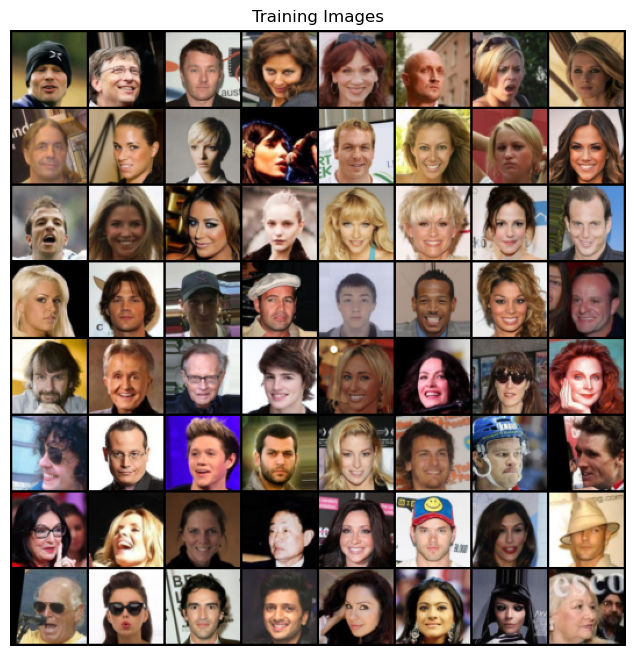

In [8]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataroot= 'data/img_align_celeba'
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

one_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Training Images')
plt.imshow(np.transpose(vutils.make_grid(one_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

# Utils

In [9]:
# custom weights initialization called on netG and netD
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [10]:
class SaveCheckpoint:
    def __init__(self, path = None):
        self.loss = np.inf
        self.path = path or os.path.join('.')
    
    def update(self, model, loss):
        if self.loss > loss:
            self.loss = loss
            self.save(model)

    def save(self, model, name):
        if isinstance(model, nn.Module):
            model = [model]
            name = [name]
        for m, n in zip(model, name):
            torch.save(m.state_dict(), '{}/{}.pth'.format(self.path, n))

# Define Models

## Generator

In [11]:
# Generator Code

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(nz, 128),
            nn.BatchNorm1d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(128, 256),
            nn.BatchNorm1d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(1024, nc * image_size * image_size),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], nc, image_size, image_size)
        return img

In [12]:
netG = Generator().to(device)
print(netG)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Linear(in_features=512, out_features=1024, bias=True)
    (10): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Linear(in_features=1024, out_features=12288, bias=True)
    (13): Tanh()
  )
)


# Discriminator

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(nc * image_size * image_size, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity


In [14]:
netD = Discriminator().to(device)
print(netD)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=12288, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [15]:
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, beta2))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, beta2))

# Gradient Penalty

In [16]:
from torch import autograd
from torch.autograd import Variable

Tensor = torch.cuda.FloatTensor

lambda_gp = 10

In [17]:
from torch import autograd

def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.randn(real_samples.size(0), 1, 1, 1, device=device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones(real_samples.shape[0], 1, device=device)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# Train

In [20]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []

total_steps = num_epochs * len(dataloader)
fig_save_interval = total_steps // 30   # animation can contain max 36 images

pbar = tqdm_nb()
piter = 0

checkpoint = SaveCheckpoint()

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    epoch_steps = len(dataloader)
    pbar.reset(total=epoch_steps)
    for i, data in enumerate(dataloader, 0):
        pbar.update()
        piter += 1
        ################################################################
        # (1) Update D network
        ################################################################
        netD.zero_grad()
        
        real_imgs = data[0].float().to(device)
        b_size = data[0].shape[0]
        noise = torch.randn(b_size, nz, device=device)

        # Generate a batch of images
        fake_imgs = netG(noise)

        real_validity = netD(real_imgs)
        fake_validity = netD(fake_imgs)
        # Gradient penalty
        gp = compute_gradient_penalty(netD, real_imgs.data, fake_imgs.data)
        
        # Adversarial loss
        errD = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gp
        errD.backward()
        optimizerD.step()
        
        # Train Generator for every 5 steps
        if i % n_critics == 0:
            ################################################################
            # (2) Update G network
            ################################################################
            netG.zero_grad()

            gen_img = netG(noise)
            errG = -torch.mean(netD(gen_img))
            errG.backward()
            optimizerG.step()

            # Output training stats
            desc = '[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f' \
                    % (epoch+1, num_epochs, i, epoch_steps, errD.item(), errG.item())
            pbar.set_description(desc)

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (piter - 1) % fig_save_interval == 0:
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append((epoch+1, i, vutils.make_grid(fake, padding=2, normalize=True)))
            print(desc)

pbar.refresh()

checkpoint.save([netG, netD], ['CelebA_netG', 'CelebA_netD'])

0it [00:00, ?it/s]

Starting Training Loop...
[1/20][0/3166] Loss_D: 8.0663 Loss_G: -0.0423
[1/20][2110/3166] Loss_D: -24.2143 Loss_G: 8.6707
[2/20][1050/3166] Loss_D: -22.9828 Loss_G: 0.9946
[2/20][3160/3166] Loss_D: -21.9452 Loss_G: 11.1242
[3/20][2105/3166] Loss_D: -17.2395 Loss_G: -1.6356
[4/20][1050/3166] Loss_D: -18.0913 Loss_G: 5.1312
[4/20][3160/3166] Loss_D: -13.9016 Loss_G: 6.6803
[5/20][2105/3166] Loss_D: -12.0651 Loss_G: 9.2841
[6/20][1050/3166] Loss_D: -12.7071 Loss_G: 8.4976
[6/20][3160/3166] Loss_D: -12.3670 Loss_G: 14.7241
[7/20][2100/3166] Loss_D: -13.9372 Loss_G: 13.0745
[8/20][1045/3166] Loss_D: -11.1929 Loss_G: 4.0675
[8/20][3155/3166] Loss_D: -8.3785 Loss_G: 4.9521
[9/20][2100/3166] Loss_D: -9.5276 Loss_G: 9.4443
[10/20][1045/3166] Loss_D: -8.9893 Loss_G: 6.5252
[10/20][3155/3166] Loss_D: -6.7355 Loss_G: 2.2850
[11/20][2100/3166] Loss_D: -8.8630 Loss_G: 0.3545
[12/20][1040/3166] Loss_D: -5.2140 Loss_G: 1.9150
[12/20][3150/3166] Loss_D: -6.3146 Loss_G: 4.4548
[13/20][2095/3166] Loss_D:

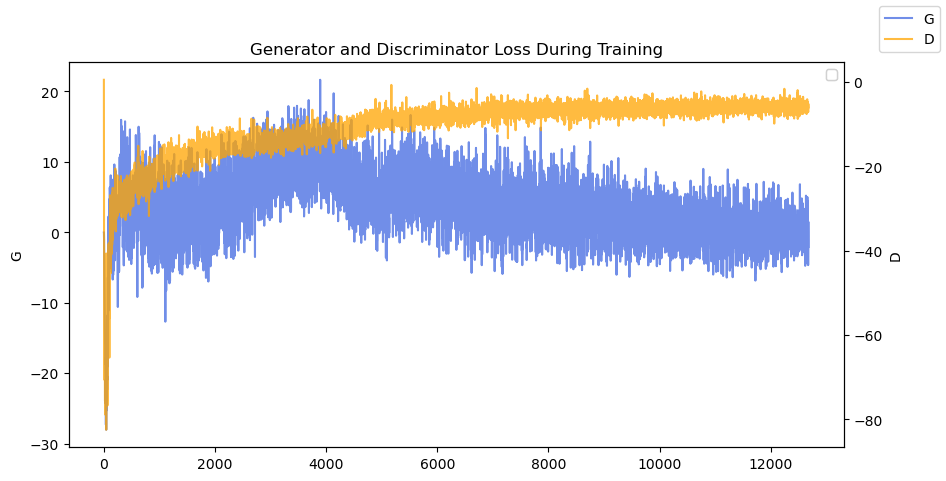

In [21]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
df = pd.DataFrame({'G': G_losses[1:], 'D': D_losses[1:]})
ax1 = sns.lineplot(data=df, x=df.index, y='G', label='G', color='royalblue', alpha=.75)
ax2 = ax1.twinx()
sns.lineplot(data=df, x=df.index, y='D', label='D', color='orange', alpha=.75, ax=ax2)
for ax in [ax1, ax2]:
#     ax.set_ylim(bottom=0.)
    ax.legend([])
ax1.figure.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.axis('off')
imgs = [[
    plt.imshow(np.transpose(img, (1,2,0)), animated=True),
    plt.text(0.5, 1.01, f'{step} iteration of {epoch} epoch', horizontalalignment='center', transform=ax.transAxes),
] for epoch, step, img in img_list]

ani = animation.ArtistAnimation(fig, imgs, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

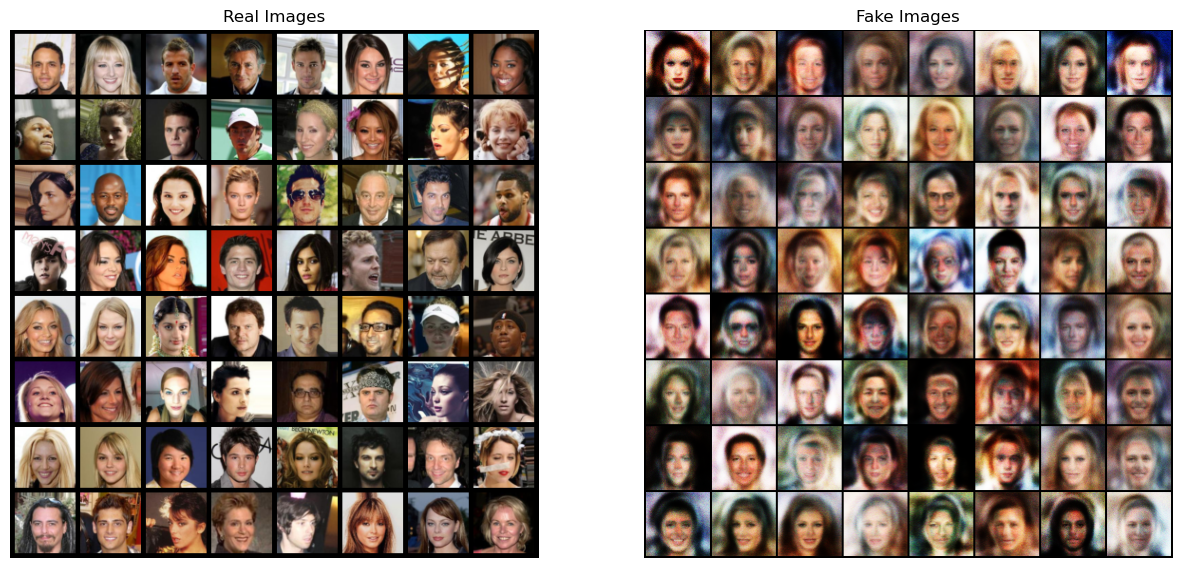

In [23]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(15, 15))

plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1][-1],(1,2,0)))
plt.show()

# Interpolation

In [24]:
def interpolate_points(p1, p2, n_steps=10):
    ratios = np.linspace(0, 1, num=n_steps)
    vs = []
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vs.append(v)
    return torch.stack(vs)

In [25]:
n1 = torch.randn(5, nz, device=device)
n2 = torch.randn(5, nz, device=device)
fake = []
for i in range(5):
    point = interpolate_points(n1[i], n2[i]).to(device)
    fake.append(netG(point))
fake = torch.vstack(fake).cpu()

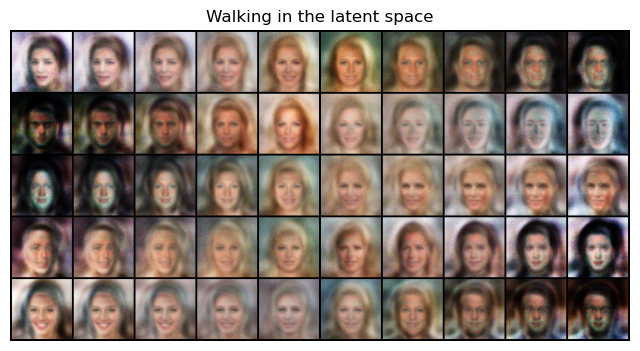

In [26]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Walking in the latent space')
plt.imshow(np.transpose(vutils.make_grid(fake, nrow=10, padding=2, normalize=True).cpu(), (1,2,0)))
plt.show()